In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %pip install --upgrade tensorflow
# %pip install keras==2.12.0
# %pip install --upgrade joblib
# %pip install scikeras

In [ ]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from keras.utils import to_categorical
from tensorflow import keras
import pywt
from tensorflow.keras.layers import Conv1D, MaxPooling1D


In [ ]:
# ------------------------------ Train Data ------------------------------ #

In [ ]:
def meg_data_generator(data_folder, task_numbers, batch_size):
  while True:
      for task in task_numbers:
          file_paths, labels = get_file_paths_and_labels(data_folder, task) # gets meg file paths from drive folder
          for i in range(0, len(file_paths), batch_size): #iterate all the files with step batch_size
              batch_paths = file_paths[i:i + batch_size]  # take the files of this batch
              batch_labels = labels[i:i + batch_size]     # and the labels

              batch_data = []
              for path in batch_paths:
                  data = load_data(path) # read the h5 file
                  data = preprocess_data(data)  # scaling, filtering, downsampling.
                  batch_data.append(data)

              batch_data_array = np.array(batch_data)
              batch_labels = np.array(batch_labels)
              print("Batch data shape:", batch_data_array.shape)
              yield batch_data_array, to_categorical(batch_labels), num_classes=4

# Helper function to get file paths and labels
def get_file_paths_and_labels(data_folder, task_numbers):
    file_paths = []
    labels = []
    for task_number in task_numbers:
        for file in os.listdir(data_folder):
            if file.endswith(task_number + 'h5'):
                file_path = os.path.join(data_folder, file)
                file_paths.append(file_path)
                labels.append(assign_label(file))
    return file_paths, labels

# Include your preprocessing steps here
def preprocess_data(data):
  data = data[:, :-8]
  print(data.shape)
  visual_data.append(data[0])
  data = min_max_scaling_per_file(data)
  print(data.shape)
  visual_data.append(data[0])
  data = apply_lowpass(data)
  visual_data.append(data[0])
  data = apply_downsampling(data)
  visual_data.append(data[0])
  data = np.transpose(data)
  print("data after preprocessing:", data.shape)
  return data.reshape((data.shape[0], data.shape[1]))

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files


def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def apply_scaling(array):
  print("array scaling", array.shape)
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

def min_max_scaling_per_file(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each file
    for file_index in range(data.shape[0]):
        file_data = data[file_index, :]

        # Compute the min and max for this file
        min_val = np.min(file_data)
        max_val = np.max(file_data)

        # Apply Min-Max scaling for this file
        scaled_data[file_index, :] = (file_data - min_val) / (max_val - min_val) if max_val != min_val else file_data

    return scaled_data


def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


def create_1d_cnn(neurons=32, optimizer='adam', timepoints=8904, sensors=248):
    model = Sequential()
    model.add(Conv1D(filters=neurons, kernel_size=3, activation="relu", input_shape=(timepoints, sensors)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=neurons * 2, kernel_size=3, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(neurons * 2, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



visual_data = []
fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
print("fmri_data_folder:", fmri_data_folder)
task_numbers = ['_1.','_2.','_3.','_4.','_5.','_6.','_7.','_8.']
batch_size = 4
epochs = 6

# Initialize model here
model = create_1d_cnn(optimizer='adam', neurons=8, sensors=248, timepoints=8904)

# Create data generator
train_generator = meg_data_generator(fmri_data_folder, task_numbers, batch_size)
print("train_generator", train_generator)


# Determine the number of steps per epoch
total_files = count_files_with_task_numbers(fmri_data_folder, task_numbers)
print(total_files)
steps_per_epoch = total_files // batch_size

# Train the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)


fmri_data_folder: /content/drive/My Drive/Courses/Pattern Recognition/Lab/Group Assignment/meg_data/Intra/train
train_generator <generator object meg_data_generator at 0x7ba914234820>
32
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
Batch data shape: (4, 8904, 248)
Epoch 1/6
1/8 [==>...........................] - ETA: 18s - loss: 1.3967 - accuracy: 0.0000e+00(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
Batch data shape: (4, 8904, 248)
2/8 [======>.......................] - ETA: 26s - loss: 3.4928 - accuracy: 0.1250    (248, 35616)
(248, 35616)
data after preprocessing: (89

(248, 35616)
(248, 35616)
data after preprocessing: (8904, 248)
(248, 35616)
(248, 35616)


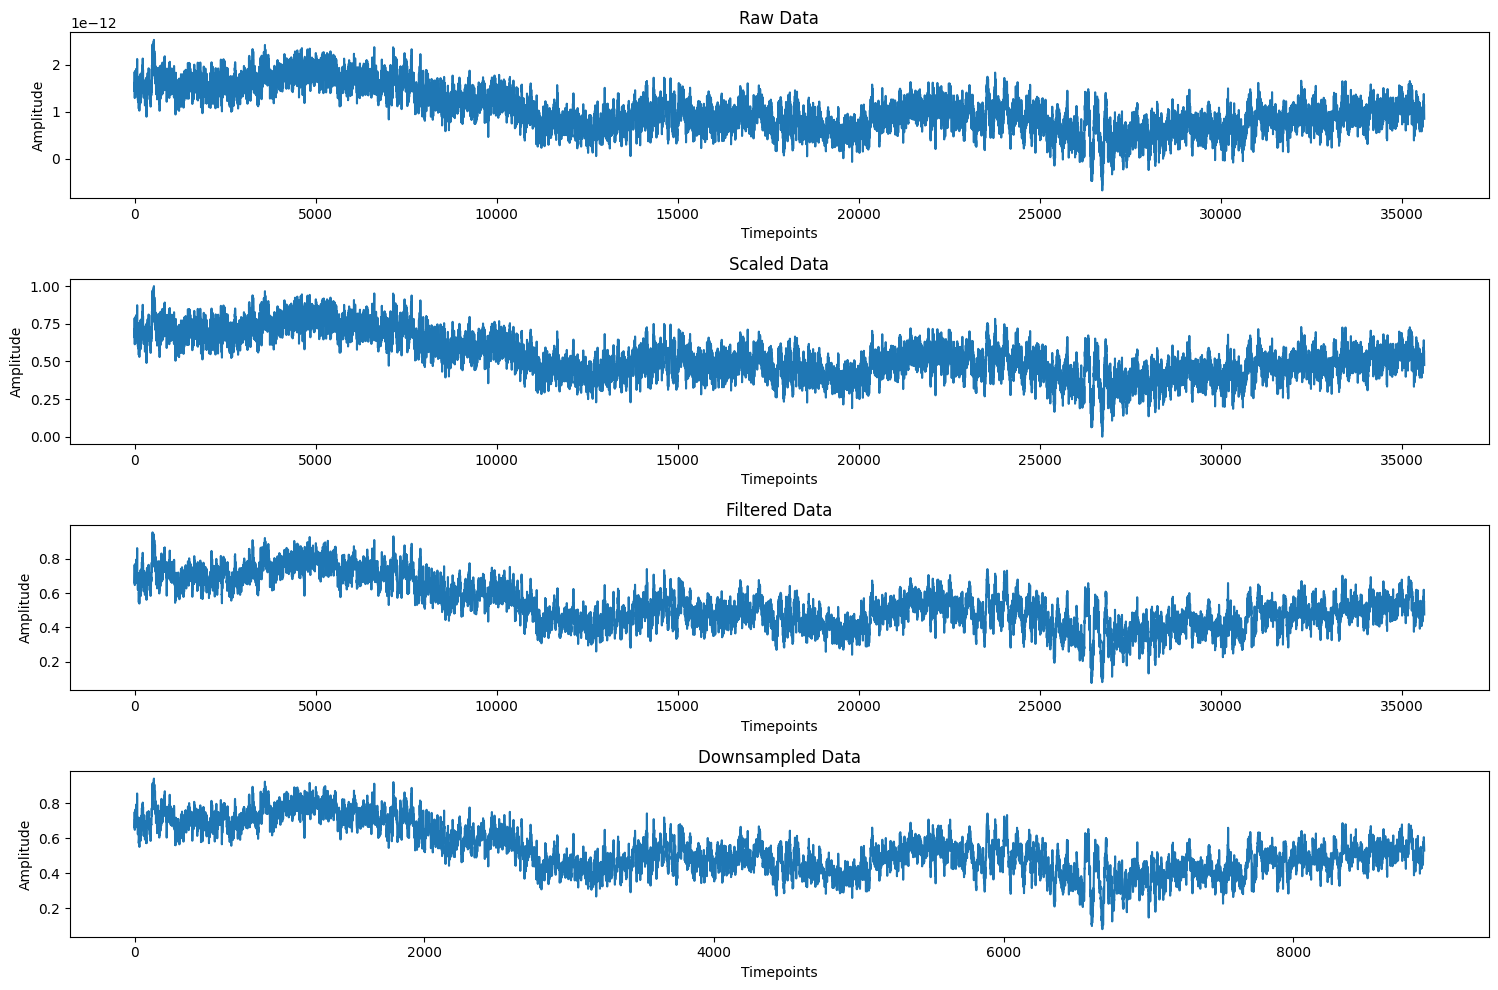

In [ ]:
# Visualize the signal of the first sensor after each step
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.

plt.figure(figsize=(15, 10))

# Plot Raw Data
plt.subplot(4, 1, 1)  # 4 rows, 1 column, 1st subplot
plt.plot(visual_data[0], label='Raw Data')
plt.title('Raw Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

# Plot Scaled Data
plt.subplot(4, 1, 2)  # 4 rows, 1 column, 2nd subplot
plt.plot(visual_data[1], label='Scaled Data')
plt.title('Scaled Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

# Plot Filtered Data
plt.subplot(4, 1, 3)  # 4 rows, 1 column, 3rd subplot
plt.plot(visual_data[2], label='Filtered Data')
plt.title('Filtered Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

# Plot Downsampled Data
plt.subplot(4, 1, 4)  # 4 rows, 1 column, 4th subplot
plt.plot(visual_data[3], label='Downsampled Data')
plt.title('Downsampled Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------ Test data ------------------------------ #

In [ ]:
# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

meg_test_data_array = meg_test_data_array[:, :, :-8]


def min_max_scaling_per_file(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each file
    for file_index in range(data.shape[0]):
        file_data = data[file_index, :, :]

        # Compute the min and max for this file
        min_val = np.min(file_data)
        max_val = np.max(file_data)

        # Apply Min-Max scaling for this file
        scaled_data[file_index, :, :] = (file_data - min_val) / (max_val - min_val) if max_val != min_val else file_data

    return scaled_data

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  new_n_timepoints = n_timepoints // 4
  downsampling_factor = 4
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


X_task_norm = min_max_scaling_per_file(meg_test_data_array)
del meg_test_data_array
gc.collect()

# Lowpass filter
X_task_filtered = apply_lowpass(X_task_norm)
del X_task_norm
gc.collect()

# Downsample
X_task_downsamp = apply_downsampling(X_task_filtered)
del X_task_filtered
gc.collect()



obs_test, sensors_test, points_test = X_task_downsamp.shape
X_test = X_task_downsamp.reshape(obs_test, sensors_test, points_test, 1)
y_test_encoded = to_categorical(labels_test_array, num_classes=4)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

1/1 [==============================] - 3s 3s/step - loss: 99.2861 - accuracy: 0.2500


In [ ]:
X_test.shape

(8, 248, 8904, 1)

In [ ]:
labels_test_array

array([1, 3, 2, 2, 1, 0, 3, 0])

In [ ]:
# Manually evaluate the model on a small batch of test data
for i in range(len(X_test)):  # Just an example to check the first few samples
    sample = np.expand_dims(X_test[i], axis=0)
    print("sample shape:", sample.shape)
    prediction = model.predict(sample)
    actual_label = np.argmax(y_test_encoded[i])
    predicted_label = np.argmax(prediction)
    print(f"Sample {i}: Actual Label = {actual_label}, Predicted Label = {predicted_label}")


sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 543ms/step
Sample 0: Actual Label = 1, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 619ms/step
Sample 1: Actual Label = 3, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 602ms/step
Sample 2: Actual Label = 2, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 725ms/step
Sample 3: Actual Label = 2, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 618ms/step
Sample 4: Actual Label = 1, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 573ms/step
Sample 5: Actual Label = 0, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] - 1s 583ms/step
Sample 6: Actual Label = 3, Predicted Label = 3
sample shape: (1, 248, 8904, 1)
1/1 [==============================] 